# 基本信息
1. 实验名称：循环神经网络
2. 姓名：龙硕
3. 学号：21281165
4. 日期：1.10

---

# 一、任务

## 1.1 任务内容

1. 理解序列数据处理方法，补全面向对象编程中的缺失代码，并使用torch自带数据工具将数据封装为dataloader



In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
import warnings
import math
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse_fn, mean_absolute_error as mae_fn
import time

warnings.filterwarnings("ignore")

In [2]:
# 定义dataset
class my_Dataset(data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]


# 空气质量数据集
class KrakowDataset:
    def __init__(self, sensor=171, is_resample=True):
        # 选取几个月个月的数据
        self.month = ['april-2017', 'august-2017', 'december-2017', 'february-2017',
                      'january-2017', 'july-2017', 'june-2017', 'march-2017',
                      'may-2017', 'november-2017', 'october-2017', 'september-2017']
        raw_data = pd.concat([pd.read_csv(f'./dataset/Krakow-airquality/{month}.csv') for month in self.month])

        # 确定特征列
        features = ['temperature', 'humidity', 'pressure', 'pm1', 'pm25', 'pm10']
        self.sensor = sensor    # 选取探测器,并非每个探测器都有数据
        self.feature_col = ['UTC time'] + [f'{self.sensor}_{fea}' for fea in features]
        data_df = raw_data[[col for col in raw_data.columns if col in self.feature_col]]

        # 按时间戳排序
        data_df['UTC time'] = pd.to_datetime(data_df['UTC time'])
        data_df = data_df.set_index('UTC time').sort_index()

        # 重采样、插分
        if is_resample:
            self.start_time, self.end_time = data_df.index.min(), data_df.index.max()
            full_index = pd.date_range(self.start_time, self.end_time, freq='h')
            data_df = data_df.reindex(full_index)
            data_df = data_df.interpolate(method='linear')
        else:
            data_df = data_df.dropna()

        # 数据标准化
        self.min = data_df.min()
        self.max = data_df.max()
        self.data = (data_df - self.min) / (self.max - self.min)

    def denormalize(self, x):
        key = f'{self.sensor}_{self.target}'
        return x * (self.max[key] - self.min[key]) + self.min[key]

    def construct_set(self, train_por=0.6, test_por=0.2, window_size=12, target='pm25'):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        self.target = target
        self.feature_col.remove('UTC time')
        self.data = self.data.reset_index()

        len_train = int(self.data.shape[0] * train_por)
        train_seqs = self.data[:len_train]
        for i in range(train_seqs.shape[0] - window_size):
            train_seq = train_seqs.loc[i:i + window_size]
            train_x.append(train_seq.loc[i:i + window_size - 1][self.feature_col].values.tolist())
            train_y.append(train_seq.loc[i + window_size][f'{self.sensor}_{target}'].tolist())

        len_val = int(self.data.shape[0] * (train_por + test_por))
        val_seqs = self.data[len_train:len_val]
        val_seqs = val_seqs.reset_index()
        for i in range(val_seqs.shape[0] - window_size):
            val_seq = val_seqs.loc[i:i + window_size]
            val_x.append(val_seq.loc[i:i + window_size - 1][self.feature_col].values.tolist())
            val_y.append(val_seq.loc[i + window_size][f'{self.sensor}_{target}'].tolist())

        test_seqs = self.data[len_val:]
        test_seqs = test_seqs.reset_index()
        for i in range(test_seqs.shape[0] - window_size):
            test_seq = test_seqs.loc[i:i + window_size]
            test_x.append(test_seq.loc[i:i + window_size - 1][self.feature_col].values.tolist())
            test_y.append(test_seq.loc[i + window_size][f'{self.sensor}_{target}'].tolist())

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set


class TrafficDataset:
    def __init__(self, sensor=10, target=0):
        # 选取适当的检测器用作序列数据
        self.raw_data = np.load('./dataset/traffic-flow/traffic.npz')['data']
        self.sensor = sensor
        self.target = target
        # 数据标准化
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por, test_por, window_size, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []

        # 补全构造过程
        pass

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set


class FourSquareDataset:
    def __init__(self, data_path):
        # 适当修改数据读取过程
        self.raw_data = pd.read_csv(data_path)
        self.min = self.raw_data.min()
        self.max = self.raw_data.max()
        self.data = (self.raw_data - self.min) / (self.max - self.min)

    def denormalize(self, x, feat):
        return x * (self.max - self.min) + self.min

    def construct_set(self, train_por, test_por, window_size, label=0):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []

        # 补全构造过程
        pass

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y))
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y))
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y))
        return train_set, val_set, test_set


In [3]:
def mape_fn(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    
    mse = mse_fn(y, pred)
    
    rmse = math.sqrt(mse)
    mae = mae_fn(y, pred)
    mape = mape_fn(y, pred)
    return [rmse, mae, mape]


# 测试函数（用于分类）
def test(net, output_model, data_iter, loss_fn, denormalize_fn, device='cpu'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    if output_model is not None:
        output_model.eval()
    for X, Y in data_iter:
        X = X.to(device).float()
        Y = Y.to(device).float()
        output, hidden = net(X)
        if output_model is not None:
            y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze(-1)
        else:
            y_hat = output[:, -1, :].squeeze(-1)
        loss = loss_fn(y_hat, Y)

        Y = denormalize_fn(Y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(Y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += loss.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count


def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,
          early_stop=10, device='cpu', output_model=None, is_print=True, is_print_batch=False):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []

    best_epoch = 0
    best_val_rmse = 9999
    early_stop_flag = 0
    for epoch in range(num_epoch):
        net.train()
        if output_model is not None:
            output_model.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            output, hidden = net(X)
            if output_model is not None:
                y_hat = output_model(output[:, -1, :].squeeze(-1)).squeeze()
            else:
                y_hat = output[:, -1, :].squeeze(-1)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            y_hat = denormalize_fn(y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1
            # sample_num += X.shape[0]

            batch_time.append(time.time() - batch_s)
            if is_print and is_print_batch:
                print('epoch-batch: %d-%d, train loss %.4f, time use %.3fs' %
                      (epoch + 1, batch_count, epoch_loss, batch_time[-1]))

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = test(net, output_model, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())

        # 打印本轮训练结果
        if is_print and (epoch + 1) % 5 == 0:
            print('*** epoch%d, train loss %.4f, train rmse %.4f, val loss %.4f, val rmse %.6f, time use %.3fs' %
                  (epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

        # 早停
        if val_score[0] < best_val_rmse:
            best_val_rmse = val_score[0]
            best_epoch = epoch
            early_stop_flag = 0
        else:
            early_stop_flag += 1
            if early_stop_flag == early_stop:
                print(f'\nThe model has not been improved for {early_stop} rounds. Stop early!')
                break

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Get best validation rmse {np.array(val_score_lst)[:, 0].min() :.4f} '
          f'at epoch {best_epoch}')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')
    print()

    # 计算测试集效果
    test_score, test_loss = test(net, output_model, test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst, epoch


def visualize(num_epochs, train_data, test_data, x_label='epoch', y_label='loss'):
    x = np.arange(0, num_epochs + 1).astype(dtype=int)
    plt.plot(x, train_data, label=f"train_{y_label}", linewidth=1)
    plt.plot(x, test_data, label=f"val_{y_label}", linewidth=1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()


def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=100)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show()

---

# 二、任务2

## 2.1 任务内容

1. 分别采用手动方式以及调用接口方式实现RNN、LSTM和GRU，并在至少一种数据集上进行实验

2. 从训练时间、预测精度、Loss变化等角度对比分析RNN、LSTM和GRU在相同数据集上的实验结果（最好使用图表展示）

3. 不同超参数的对比分析（包括hidden_size、batch_size、lr等）选其中至少1-2个进行分析

## 手动实现RNN

In [4]:
## 第一部分：网络定义
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
        :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
        :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
        """
        super().__init__()
        self.hidden_size = hidden_size
        
        # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()
        
        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        """
        :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
        """
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + 
                             torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        return torch.stack(y_list, dim=1), h

In [5]:
##第二部分：加载数据集，生成迭代器
KrakowData = KrakowDataset()
train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)

batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
train_loader

In [6]:
##第三部分：测试指标RMSE、MAE和MAPE
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [7]:
#第四部分：模型初始化并进行训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_rnn = MyRNN(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_rnn.parameters(), lr)

In [8]:
train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch5, train loss 0.0030, train rmse 15.2202, val loss 0.0005, val rmse 6.367938, time use 0.233s
*** epoch10, train loss 0.0019, train rmse 12.0469, val loss 0.0003, val rmse 4.648235, time use 0.388s
*** epoch15, train loss 0.0014, train rmse 10.4671, val loss 0.0002, val rmse 4.033236, time use 0.281s
*** epoch20, train loss 0.0012, train rmse 9.5127, val loss 0.0002, val rmse 3.883871, time use 0.466s
*** epoch25, train loss 0.0011, train rmse 8.9737, val loss 0.0002, val rmse 3.498667, time use 0.344s
*** epoch30, train loss 0.0010, train rmse 8.6619, val loss 0.0001, val rmse 3.376928, time use 0.219s
*** epoch35, train loss 0.0009, train rmse 8.3614, val loss 0.0001, val rmse 3.270610, time use 0.259s
*** epoch40, train loss 0.0009, train rmse 8.2595, val loss 0.0002, val rmse 4.342185, time use 0.509s
*** epoch45, train loss 0.0009, train rmse 8.1802, val loss 0.0002, val rmse 4.202797, time use 0.250s
*** epoch50, train loss 0.0008, train rmse 8.0279, val loss 0.0001, val

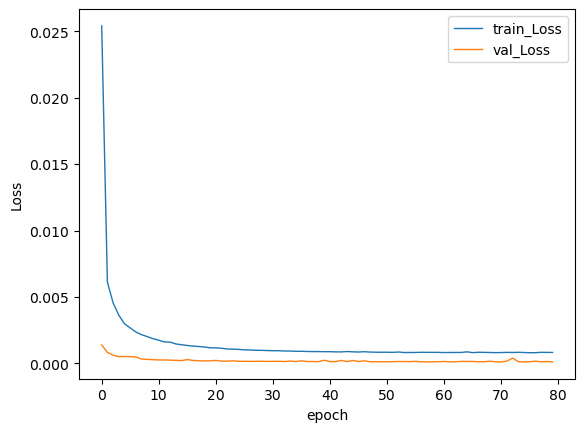

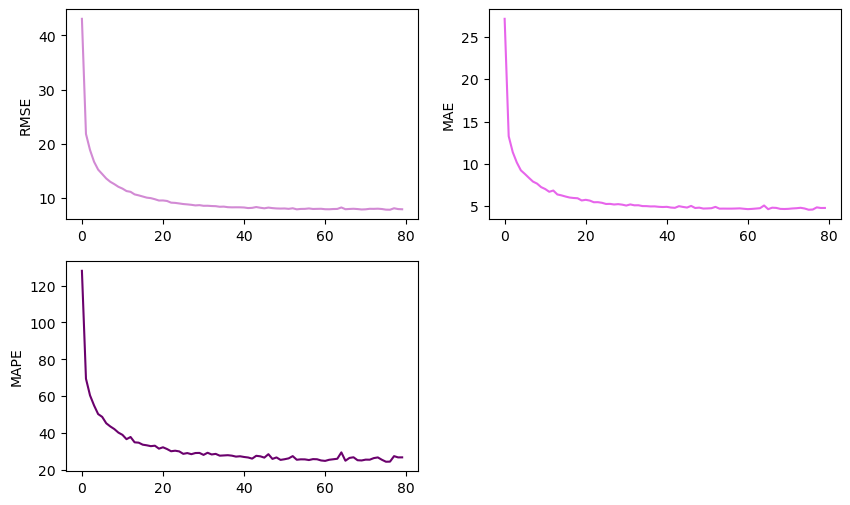

In [9]:
#第五部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## 调包实现RNN

In [10]:
#第一部分：调用RNN并进行训练

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_rnn.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_rnn, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch5, train loss 0.0028, train rmse 14.6442, val loss 0.0003, val rmse 4.818193, time use 0.141s
*** epoch10, train loss 0.0019, train rmse 12.2302, val loss 0.0002, val rmse 3.817019, time use 0.406s
*** epoch15, train loss 0.0016, train rmse 10.8923, val loss 0.0002, val rmse 3.671963, time use 0.379s
*** epoch20, train loss 0.0014, train rmse 10.1401, val loss 0.0001, val rmse 3.377452, time use 0.361s
*** epoch25, train loss 0.0012, train rmse 9.7121, val loss 0.0001, val rmse 3.264595, time use 0.389s
*** epoch30, train loss 0.0011, train rmse 9.2752, val loss 0.0002, val rmse 3.456835, time use 0.261s
*** epoch35, train loss 0.0010, train rmse 8.9244, val loss 0.0001, val rmse 3.336161, time use 0.225s
*** epoch40, train loss 0.0010, train rmse 8.6588, val loss 0.0001, val rmse 3.213110, time use 0.172s
*** epoch45, train loss 0.0009, train rmse 8.4659, val loss 0.0001, val rmse 3.124300, time use 0.297s
*** epoch50, train loss 0.0009, train rmse 8.2437, val loss 0.0001, va

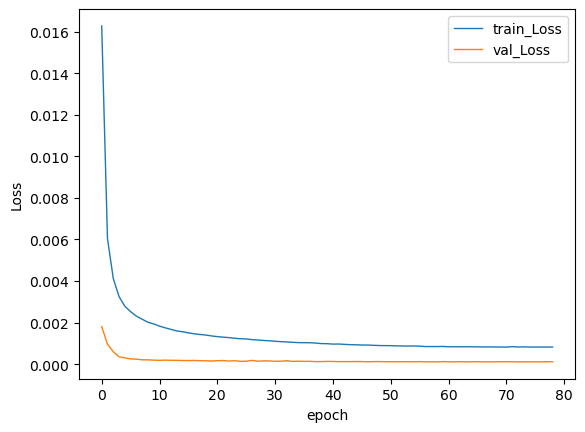

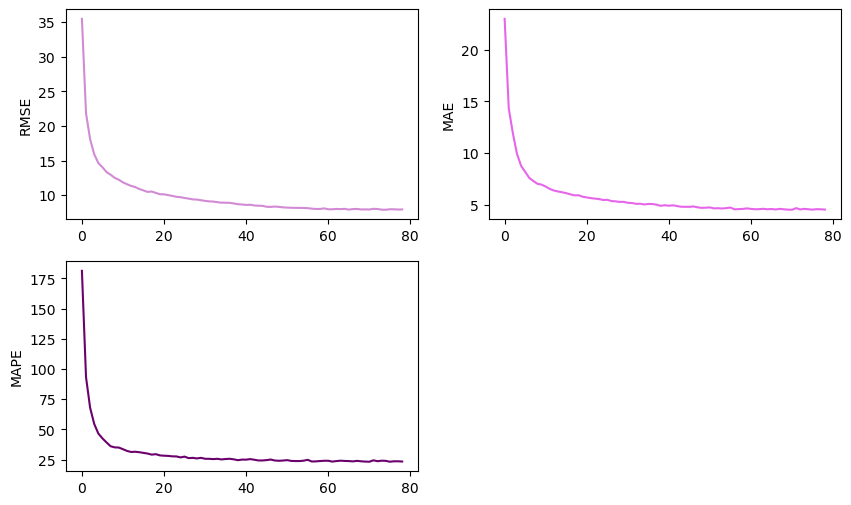

In [11]:
#第二部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## 手动实现LSTM

In [12]:
## 第一部分：定义网络
class My_LSTM(nn. Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn. Tanh()
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h, c = (torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(2))
        y_list = []
        for i in range(seq_len):
            forget_gate, input_gate, output_gate, candidate_cell = \
                self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
            forget_gate, input_gate, output_gate = (self.sigmoid(g)
                                                    for g in (forget_gate, input_gate, output_gate))
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), (h, c)

In [13]:
#第二部分：模型初始化并进行训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_lstm_modern = My_LSTM(input_size, hidden_size,output_size).to(device)

optimizer = torch.optim.Adam(my_lstm_modern.parameters(), lr)

In [14]:
train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_lstm_modern, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch5, train loss 0.0033, train rmse 16.1264, val loss 0.0003, val rmse 4.369860, time use 1.448s
*** epoch10, train loss 0.0023, train rmse 13.4170, val loss 0.0002, val rmse 3.757640, time use 0.861s
*** epoch15, train loss 0.0018, train rmse 11.7102, val loss 0.0002, val rmse 3.914143, time use 0.764s
*** epoch20, train loss 0.0015, train rmse 10.6970, val loss 0.0002, val rmse 3.538183, time use 0.738s
*** epoch25, train loss 0.0013, train rmse 9.9558, val loss 0.0001, val rmse 3.335699, time use 0.663s
*** epoch30, train loss 0.0012, train rmse 9.5587, val loss 0.0002, val rmse 3.870234, time use 0.676s
*** epoch35, train loss 0.0011, train rmse 9.0599, val loss 0.0002, val rmse 3.576894, time use 1.112s
*** epoch40, train loss 0.0010, train rmse 8.7410, val loss 0.0001, val rmse 3.129581, time use 1.004s
*** epoch45, train loss 0.0009, train rmse 8.4876, val loss 0.0001, val rmse 3.177972, time use 0.605s
*** epoch50, train loss 0.0009, train rmse 8.4194, val loss 0.0001, va

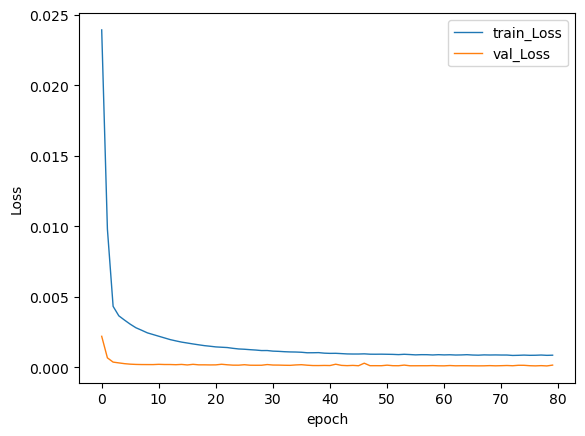

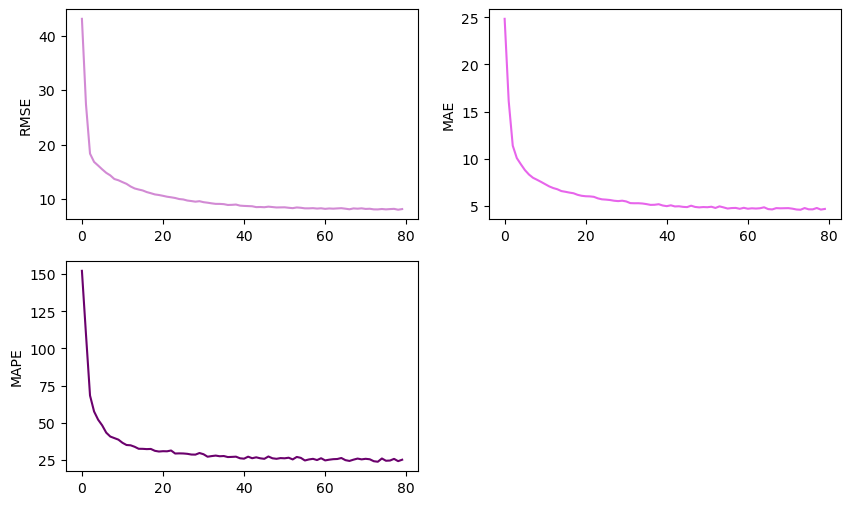

In [15]:
#第三部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## 调包实现LSTM

In [16]:
#第一部分：调用LSTM并进行训练

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_lstm.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_lstm, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch5, train loss 0.0047, train rmse 19.2990, val loss 0.0004, val rmse 5.791008, time use 0.249s
*** epoch10, train loss 0.0034, train rmse 16.4388, val loss 0.0003, val rmse 4.609867, time use 0.599s
*** epoch15, train loss 0.0025, train rmse 13.9608, val loss 0.0002, val rmse 4.020332, time use 0.188s
*** epoch20, train loss 0.0020, train rmse 12.6063, val loss 0.0002, val rmse 3.828850, time use 0.202s
*** epoch25, train loss 0.0016, train rmse 11.0500, val loss 0.0002, val rmse 3.570862, time use 0.220s
*** epoch30, train loss 0.0013, train rmse 9.9294, val loss 0.0001, val rmse 3.361072, time use 0.172s
*** epoch35, train loss 0.0012, train rmse 9.4226, val loss 0.0002, val rmse 3.404591, time use 0.188s
*** epoch40, train loss 0.0011, train rmse 9.1902, val loss 0.0001, val rmse 3.110762, time use 0.190s
*** epoch45, train loss 0.0010, train rmse 8.9049, val loss 0.0001, val rmse 3.245880, time use 0.234s
*** epoch50, train loss 0.0010, train rmse 8.7948, val loss 0.0002, v

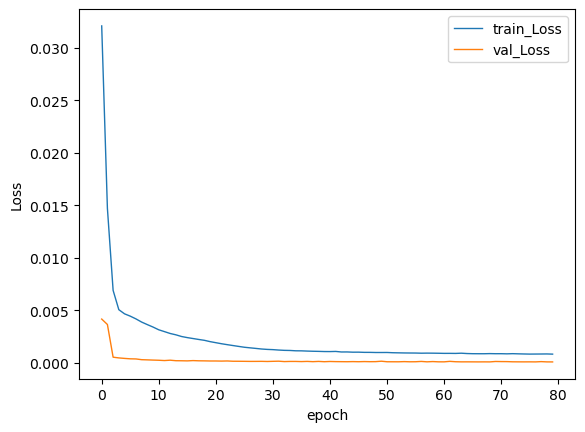

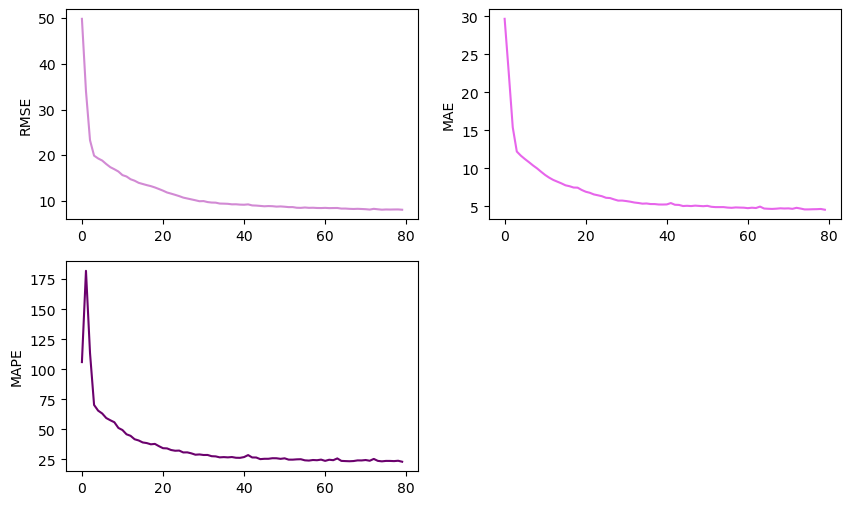

In [17]:
#第二部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## 手动实现GRU

In [18]:
## 第一部分：网络定义
class My_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.gates = nn.Linear(input_size+hidden_size, hidden_size*2)
        # 用于计算candidate hidden state
        self.hidden_transform = nn.Linear(input_size+hidden_size, hidden_size)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
            
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            update_gate, reset_gate = self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(2, -1)
            update_gate, reset_gate = (self.sigmoid(gate) for gate in (update_gate, reset_gate))
            candidate_hidden = self.tanh(self.hidden_transform(torch.cat([x[:, i, :], reset_gate * h], dim=-1)))
            h = (1-update_gate) * h + update_gate * candidate_hidden
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), h

In [19]:
##第二部分：加载数据集，生成迭代器
KrakowData = KrakowDataset()
train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)

batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
train_loader

In [20]:
##第三部分：测试指标RMSE、MAE和MAPE
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [21]:
#第四部分：模型初始化并进行训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_gru = My_GRU(input_size, hidden_size, output_size).to(device)

optimizer = torch.optim.Adam(my_gru.parameters(), lr)

In [22]:
train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_gru, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch5, train loss 0.0020, train rmse 12.4234, val loss 0.0002, val rmse 3.944487, time use 0.670s
*** epoch10, train loss 0.0014, train rmse 10.4501, val loss 0.0002, val rmse 3.637758, time use 0.751s
*** epoch15, train loss 0.0012, train rmse 9.4078, val loss 0.0002, val rmse 3.885287, time use 0.750s
*** epoch20, train loss 0.0010, train rmse 8.8686, val loss 0.0002, val rmse 3.367937, time use 0.743s
*** epoch25, train loss 0.0010, train rmse 8.6340, val loss 0.0001, val rmse 3.326866, time use 0.596s
*** epoch30, train loss 0.0009, train rmse 8.4142, val loss 0.0002, val rmse 3.684782, time use 0.709s
*** epoch35, train loss 0.0009, train rmse 8.1108, val loss 0.0001, val rmse 2.908448, time use 0.754s
*** epoch40, train loss 0.0009, train rmse 8.1712, val loss 0.0001, val rmse 3.121425, time use 0.862s
*** epoch45, train loss 0.0008, train rmse 8.0722, val loss 0.0001, val rmse 2.862544, time use 0.793s
*** epoch50, train loss 0.0008, train rmse 7.9293, val loss 0.0001, val 

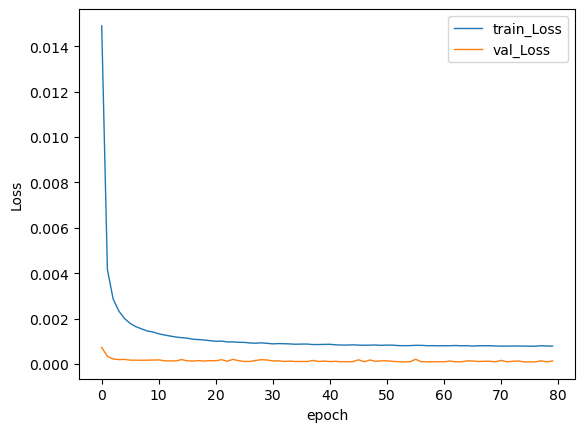

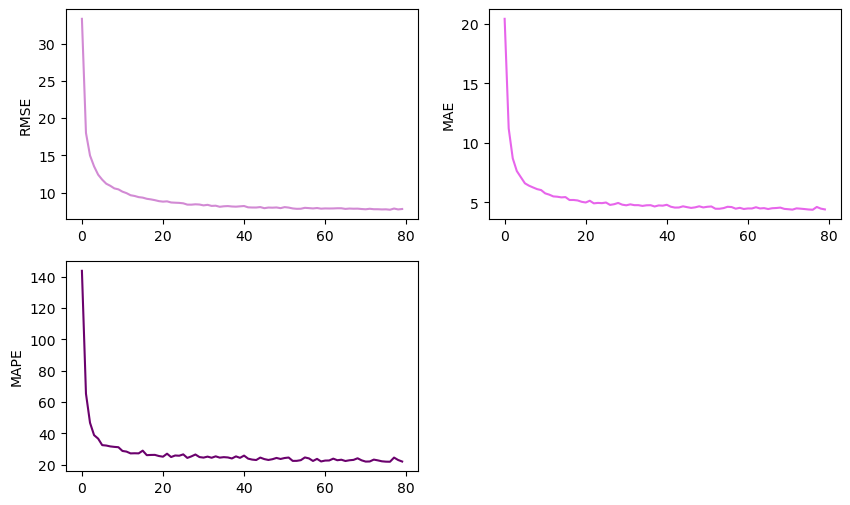

In [23]:
#第五部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## 调包实现GRU

In [24]:
#第一部分：调用RNN并进行训练

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_gru.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_gru, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch5, train loss 0.0038, train rmse 17.3960, val loss 0.0004, val rmse 5.242188, time use 0.406s
*** epoch10, train loss 0.0025, train rmse 13.8217, val loss 0.0002, val rmse 3.865679, time use 0.495s
*** epoch15, train loss 0.0018, train rmse 11.8749, val loss 0.0002, val rmse 3.530264, time use 0.476s
*** epoch20, train loss 0.0015, train rmse 10.6941, val loss 0.0002, val rmse 3.516452, time use 0.947s
*** epoch25, train loss 0.0013, train rmse 9.9681, val loss 0.0002, val rmse 3.682890, time use 0.500s
*** epoch30, train loss 0.0012, train rmse 9.5610, val loss 0.0001, val rmse 3.332860, time use 0.300s
*** epoch35, train loss 0.0011, train rmse 9.2296, val loss 0.0002, val rmse 3.762720, time use 0.526s
*** epoch40, train loss 0.0010, train rmse 8.9520, val loss 0.0002, val rmse 3.428744, time use 0.422s
*** epoch45, train loss 0.0010, train rmse 8.7506, val loss 0.0001, val rmse 3.221713, time use 0.561s
*** epoch50, train loss 0.0010, train rmse 8.5763, val loss 0.0001, va

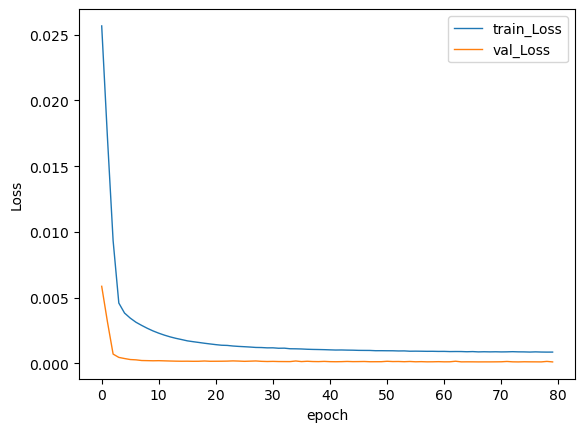

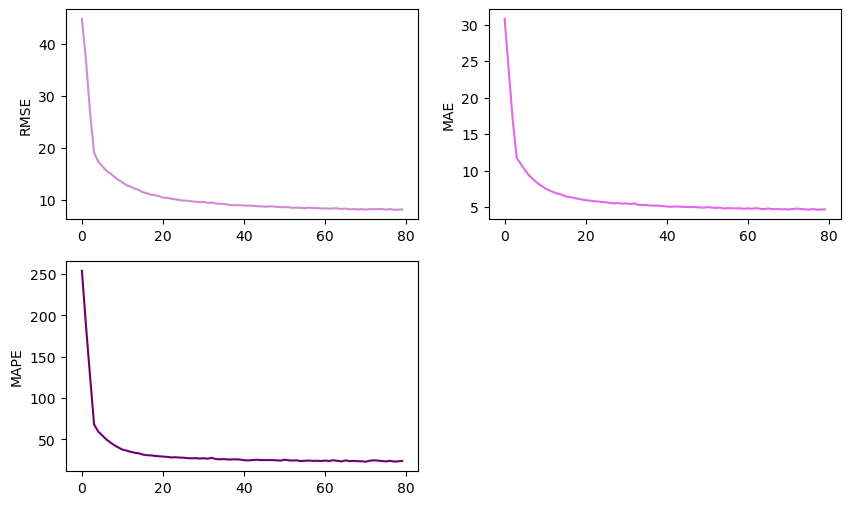

In [25]:
#第二部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

---

# A1 实验心得

> 1. 请重视总结心得体会，该部分计分；
> 2. 至少应包括一个具体任务心得或代码排错过程，而不是仅有诸如“学到了很多”的内容。

# A2 参考文献

> 主要包含实验过程中涉及到的参考资料或者借鉴别人的材料等，如果没有可以不写。

1. 参考文献1；
2. 参考文献2；
3. ……